In [8]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd

from keras.models import Model, Sequential
from keras.layers import Input
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_tuner import  Objective, BayesianOptimization
from Builder_tools.Unit_tools import MyHyperModel, create_model
from keras.callbacks import ModelCheckpoint
from livelossplot.tf_keras import PlotLossesCallback
from Builder_tools.preprocess_func import preprocess_input_VGG16
from keras.applications import VGG16

### Загрузка csv файла

In [6]:
# Загрузка csv файла
df = pd.read_csv('./V_A_data/V_A_train.csv', index_col = 0)

# Разделим на обучающий и тренировочный датасеты
train_df = df[df['train_test']== 'train'].copy()
test_df = df[df['train_test']== 'test'].copy()

### МОДЕЛЬ VGGFace на архитектуре VGG16

In [9]:
# Инициализируем модель
vggface16_model = VGG16(weights='rcmalli_vggface_tf_notop_vgg16.h5',
     include_top=False,
     input_shape=(224,224,3))

vggface16_model.trainable = False
vggface16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Создание генераторов для обучающих и тестовых данных

In [38]:
BATCH_SIZE = 14
IMAGE_SIZE = 224

# Функция препроцессинга на вход тензор размера (1, H, W, 3) + аугментации
train_generator = ImageDataGenerator(rotation_range=15,
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     brightness_range=(0.5,1.5),
                                     shear_range=0.1,
                                     zoom_range=.1,
                                     preprocessing_function=preprocess_input_VGG16 # Препроцессинг для VGG16
                                    ) 

# train generator
train_data_gen = train_generator.flow_from_dataframe(dataframe=train_df,
                                                     x_col='path',
                                                     y_col=['Valence','Arousal'],
                                                     target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='raw',
                                                     shuffle=True,
                                                     interpolation='nearest'
                                                    )

# validation generator
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input_VGG16)

val_data_gen = val_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='path',
                                                 y_col=['Valence','Arousal'],
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='raw',
                                                 shuffle=False,
                                                 interpolation='nearest'
                                                )

Found 45813 validated image filenames.
Found 8100 validated image filenames.


In [39]:
# Размораживаем все слои базовой модели
vggface16_model.trainable = True

# Оставляем только последние 4 слоя
for i_layer in vggface16_model.layers[:-4]:
    i_layer.trainable = False

model = create_model(
    base_model=vggface16_model,
    start_units=288,
    activation_ch = 'relu', 
    num_layers_start= 2,
    dropout_rate = 0.25, 
    output_num=2
    )

model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_24 (Dense)            (None, 288)               7225632   
                                                                 
 batch_normalization_18 (Ba  (None, 288)               1152      
 tchNormalization)                                               
                                                                 
 activation_19 (Activation)  (None, 288)               0         
                                                                 
 dropout_18 (Dropout)        (None, 288)               0         
                                                      

In [44]:
# Компиляция модели
checkpoint = ModelCheckpoint('./check_points/VGG16_V_A/VGGFace_V_A',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='val_loss')

# Будем использовать оптимизатор Адам с динамическим изменением скорости обучения
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=5500,
    decay_rate=0.9)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics='mean_absolute_error')


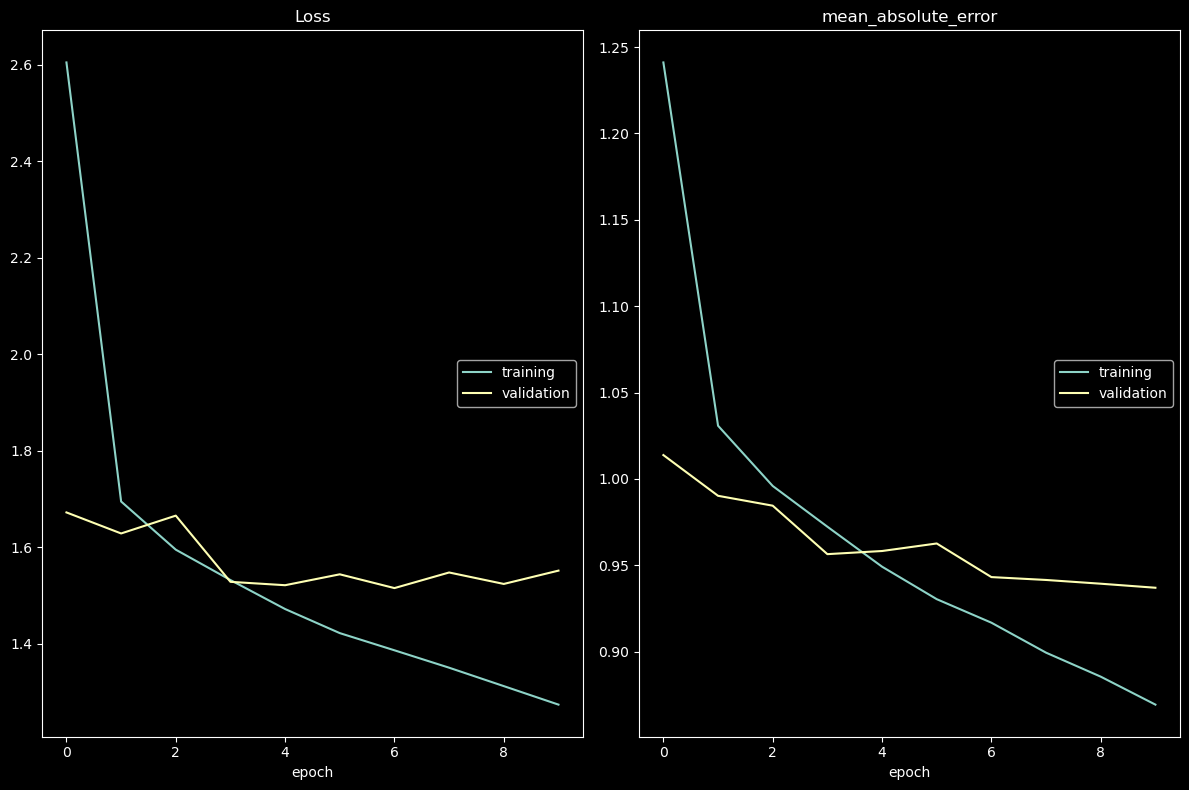

Loss
	training         	 (min:    1.274, max:    2.604, cur:    1.274)
	validation       	 (min:    1.515, max:    1.672, cur:    1.551)
mean_absolute_error
	training         	 (min:    0.869, max:    1.241, cur:    0.869)
	validation       	 (min:    0.937, max:    1.014, cur:    0.937)
3273/3273 [==============================] - 416s 127ms/step - loss: 1.2738 - mean_absolute_error: 0.8694 - val_loss: 1.5514 - val_mean_absolute_error: 0.9371


In [45]:
# Обучение модели
EPOCHS = 10
history = model.fit(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen,
                    callbacks=[checkpoint, PlotLossesCallback()])

In [46]:
# Загружаем лучшие веса
model.load_weights('./check_points/VGG16_V_A/VGGFace_V_A')
# Сохраняем модель 
model.save('./saved_models/VGG16_V_A')

INFO:tensorflow:Assets written to: ./saved_models/VGG16_V_A/assets


INFO:tensorflow:Assets written to: ./saved_models/VGG16_V_A/assets


In [47]:
model.evaluate(val_data_gen)

579/579 [==============================] - 33s 58ms/step - loss: 1.5152 - mean_absolute_error: 0.9432


[1.5151891708374023, 0.9432231783866882]